# Preventing Overfitting with Ridge and Lasso Regression Demo

## Create a dataset based $y = \sin(4x)$
Let's look at a synthetic dataset consisting of 30 points drawn from the sinusoid $y = \sin(4x)$:

In [1]:
import numpy as np
import pandas as pd
import math
import random
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from matplotlib import pyplot as plt
%matplotlib inline

Create random values for x in interval [0,1)

In [2]:
random.seed(98103)
n = 30
x = pd.Series(sorted([random.random() for i in range(n)]))

Compute y

In [3]:
y = pd.Series(x.apply(lambda x: math.sin(4*x)))

Add random Gaussian noise to y

In [4]:
random.seed(1)
e = pd.Series([random.gauss(0,1.0/3.0) for i in range(n)])
y = y + e

### Put data into a data frame to manipulate later

In [5]:
data = pd.concat({'X1':x, 'Y':y}, axis=1)
data.head()

,X1,Y
0,0.039579,0.587050
1,0.041568,0.648656
2,0.072432,0.307803
3,0.150289,0.310748
4,0.161334,0.237410


### Create a function to plot the data, since we'll do it many times

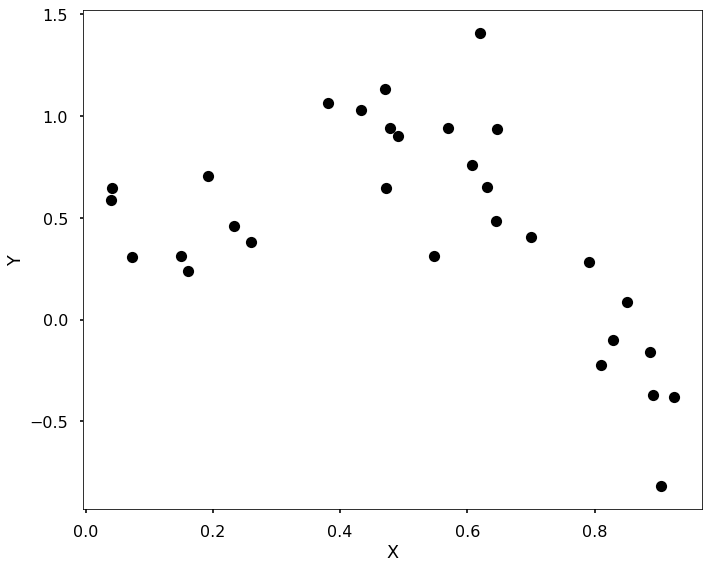

In [7]:
def plot_data(data):
    plt.style.use('seaborn-poster')
    plt.plot(data['X1'],data['Y'],'k.', marker='o')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.gcf().set_size_inches(10,8)
    plt.tight_layout()

plot_data(data)

## Define some useful polynomial regression functions

Define a function to create our features for a polynomial regression model of any degree:

In [8]:
def polynomial_features(data, deg):
    data_copy=data.copy()
    for i in range(1,deg):
        data_copy['X'+str(i+1)]=data_copy['X'+str(i)]*data_copy['X1']
    return data_copy

Define a function to fit a polynomial linear regression model of degree "deg" to the data in "data":

In [9]:
def polynomial_regression(data, deg):
    y = data.Y
    Xs = polynomial_features(data[['X1']],deg)
    model = LinearRegression().fit(Xs, y)
    return model

Define function to plot data and predictions made, since we are going to use it many times.

In [10]:
def plot_poly_predictions(data, model):
    plot_data(data)

    # Get the degree of the polynomial
    deg = len(model.coef_)

    # Create 200 points in the x axis and compute the predicted value 
    # for each point
    x_pred = pd.DataFrame(data=[[i/200.0] for i in range(200)], columns=['X1'])
    Xs_pred = polynomial_features(x_pred,deg)
    y_pred = model.predict(Xs_pred)
    
    # plot predictions
    plt.plot(x_pred['X1'], y_pred, 'g-', lw=5, label='degree ' + str(deg) + ' fit')
    plt.legend(loc='upper left')
    plt.axis([0,1,-1.5,2])

Create a function that prints the polynomial coefficients.

In [11]:
def print_coefficients(model):    
    # Get the degree of the polynomial
    deg = len(model.coef_)

    # Get learned parameters as a list
    w = list(model.coef_) + [model.intercept_]

    # Numpy has a nifty function to print out polynomials in a pretty way
    print('Learned polynomial for degree ' + str(deg) + ':')
    print(np.poly1d(w))

## Fit a degree-2 polynomial

Fit our degree-2 polynomial to the data generated above:

In [12]:
model = polynomial_regression(data, deg=2)

Inspect learned parameters

In [13]:
print_coefficients(model)

Learned polynomial for degree 2:
       2
4.147 x - 5.129 x + 0.07471


Form and plot our predictions along a grid of x values:

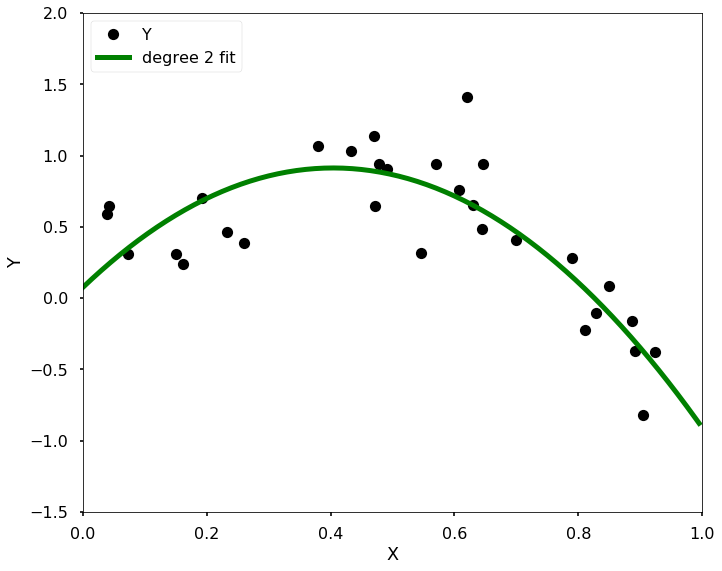

In [14]:
plot_poly_predictions(data, model)

## Fit a degree-4 polynomial

Learned polynomial for degree 4:
        4         3         2
-6.828 x + 35.23 x - 53.82 x + 23.87 x + 0.7755


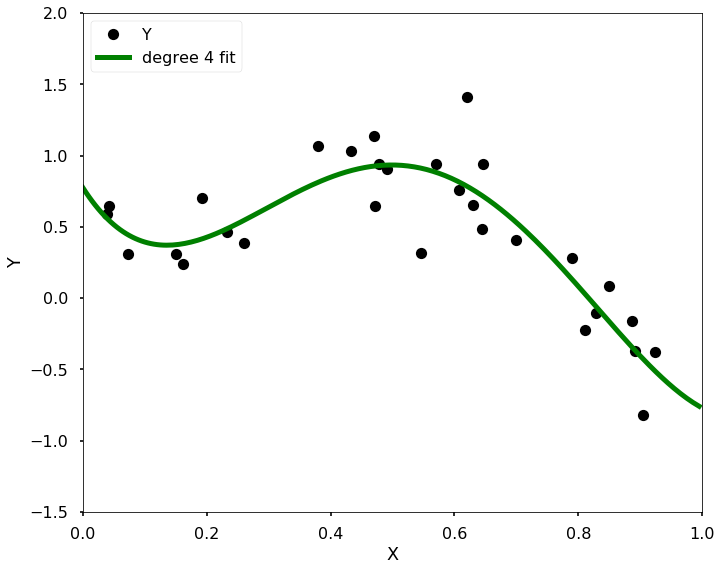

In [15]:
model = polynomial_regression(data, deg=4)
print_coefficients(model)
plot_poly_predictions(data,model)

## Fit a degree-16 polynomial

In [16]:
model = polynomial_regression(data, deg=16)
print_coefficients(model)

Learned polynomial for degree 16:
       16             15             14             13             12
839.5 x  - 2.188e+04 x  + 3.019e+05 x  - 2.549e+06 x  + 1.394e+07 x 
              11             10             9             8
 - 4.739e+07 x  + 6.714e+07 x  + 2.252e+08 x - 1.656e+09 x
              7             6             5             4             3
 + 5.137e+09 x - 9.998e+09 x + 1.309e+10 x - 1.156e+10 x + 6.619e+09 x
              2
 - 2.225e+09 x + 3.337e+08 x - 12.01


### Note the HUGE coefficients!

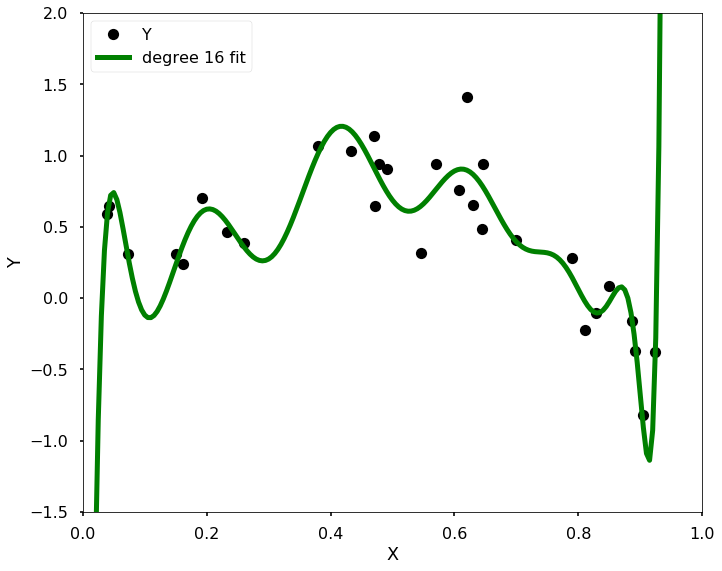

In [17]:
plot_poly_predictions(data,model)

### Above: Fit looks pretty wild, too. Here's a clear example of how overfitting is associated with very large magnitude estimated coefficients.

# Ridge Regression

Ridge regression aims to avoid overfitting by adding a cost to the RSS term of standard least squares that depends on the 2-norm of the coefficients $\|w\|$.  The result is penalizing fits with large coefficients.  The strength of this penalty, and thus the fit vs. model complexity balance, is controled by a parameter lambda (here called "L2_penalty").

Define our function to solve the ridge objective for a polynomial regression model of any degree:

In [18]:
def polynomial_ridge_regression(data, deg, l2_penalty):
    y = data.Y
    Xs = polynomial_features(data[['X1']],deg)
    model = Ridge(alpha=l2_penalty).fit(Xs, y)
    return model

## Perform a ridge fit of a degree-16 polynomial using a *very* small penalty strength

In [19]:
model = polynomial_ridge_regression(data, deg=16, l2_penalty=1e-14)
print_coefficients(model)

Learned polynomial for degree 16:
        16         15         14            13             12
-47.82 x  + 368.8 x  + 781.1 x  - 2.46e+04 x  + 1.373e+05 x 
              11             10             9             8
 - 3.471e+05 x  + 3.715e+05 x  + 3.457e+04 x - 3.188e+05 x
              7            6             5             4             3
 - 3.745e+04 x + 2.55e+05 x + 1.052e+05 x - 1.748e+05 x - 1.279e+05 x
              2
 + 1.597e+05 x - 3.377e+04 x + 1.956


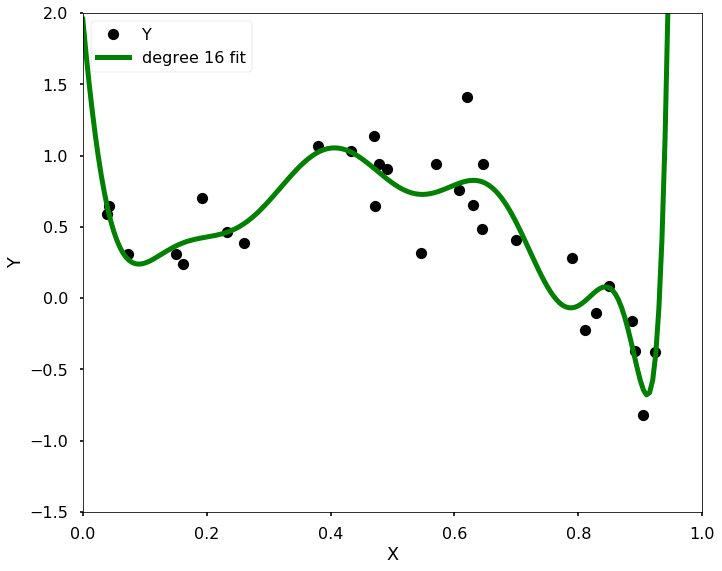

In [20]:
plot_poly_predictions(data,model)

## Perform a ridge fit of a degree-16 polynomial using a very large penalty strength

In [21]:
model = polynomial_ridge_regression(data, deg=16, l2_penalty=100)
print_coefficients(model)

Learned polynomial for degree 16:
          16           15           14           13           12
-0.01594 x  - 0.02253 x  - 0.02439 x  - 0.02397 x  - 0.02253 x 
           11           10           9           8           7
 - 0.0207 x  - 0.01879 x  - 0.01694 x - 0.01521 x - 0.01364 x
            6           5            4            3           2
 - 0.01222 x - 0.01095 x - 0.009809 x - 0.008794 x - 0.00789 x - 0.007084 x + 0.4948


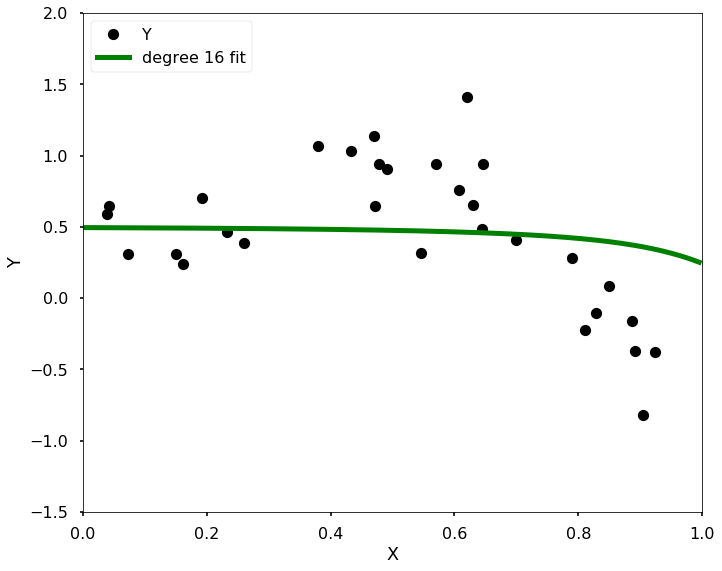

In [22]:
plot_poly_predictions(data,model)

## Let's look at fits for a sequence of increasing lambda values

lambda = 1.00e-14
Learned polynomial for degree 16:
        16         15         14            13             12
-47.82 x  + 368.8 x  + 781.1 x  - 2.46e+04 x  + 1.373e+05 x 
              11             10             9             8
 - 3.471e+05 x  + 3.715e+05 x  + 3.457e+04 x - 3.188e+05 x
              7            6             5             4             3
 - 3.745e+04 x + 2.55e+05 x + 1.052e+05 x - 1.748e+05 x - 1.279e+05 x
              2
 + 1.597e+05 x - 3.377e+04 x + 1.956


lambda = 1.00e-10
Learned polynomial for degree 16:
        16         15         14         13        12        11
-4.716 x  - 11.39 x  + 100.6 x  + 769.9 x  - 4281 x  + 4893 x 
         10        9        8         7        6        5         4
 + 3439 x  - 4252 x - 6056 x - 498.1 x + 5802 x + 6541 x + 714.5 x
         3        2
 - 6900 x - 7803 x + 7567 x + 0.7859


lambda = 1.00e-06
Learned polynomial for degree 16:
        16         15         14         13         12         11
-9.752 x  + 52.95 x

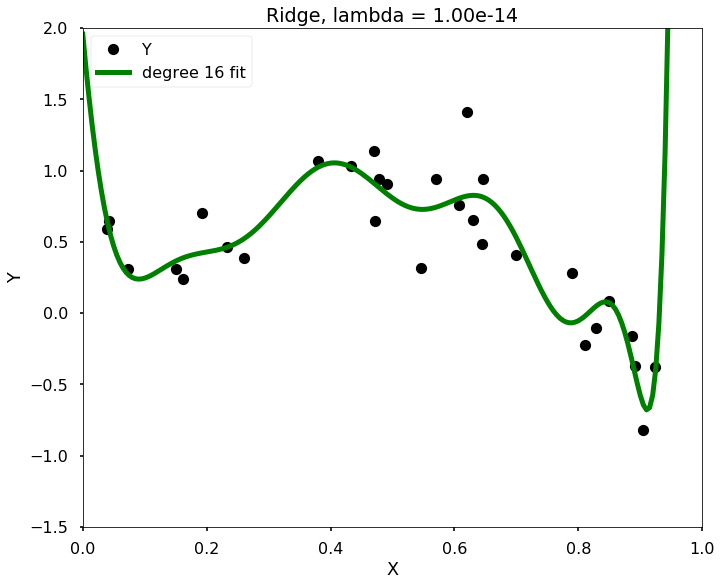

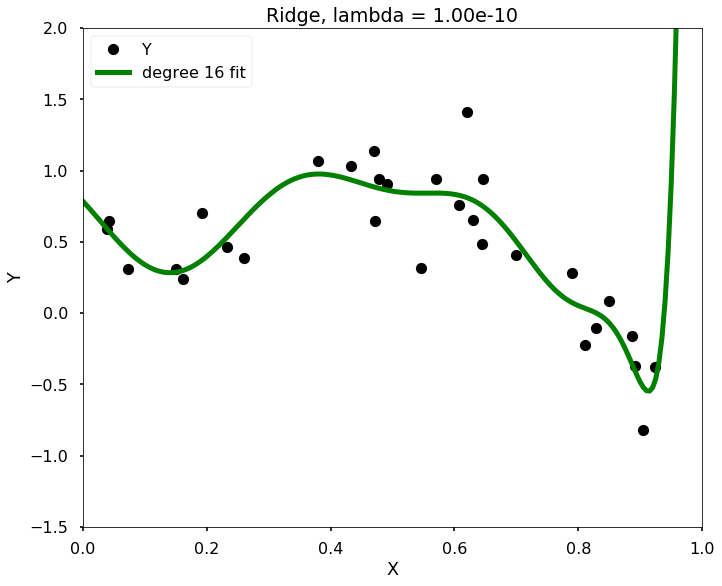

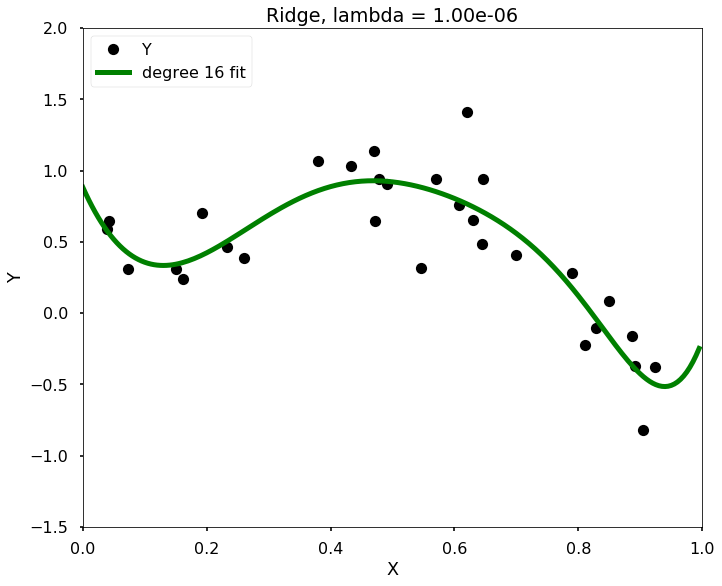

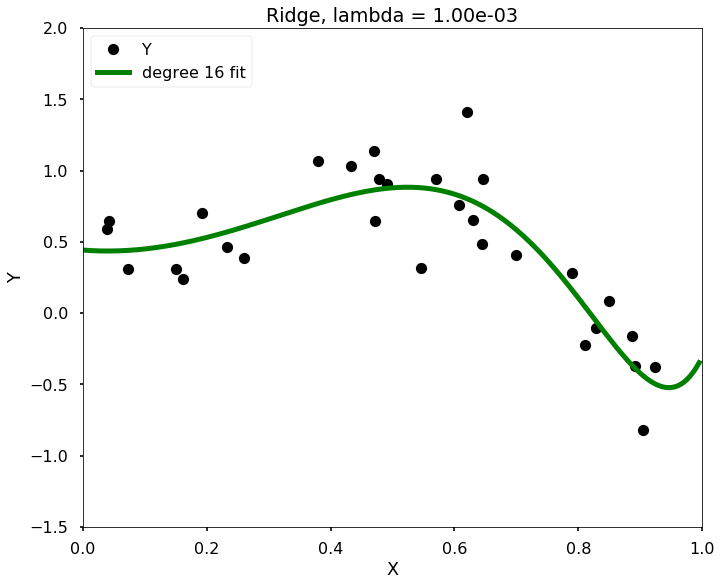

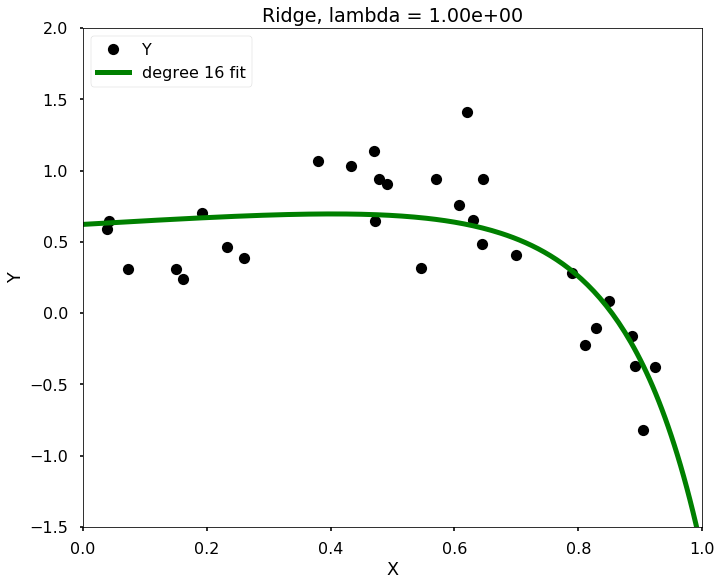

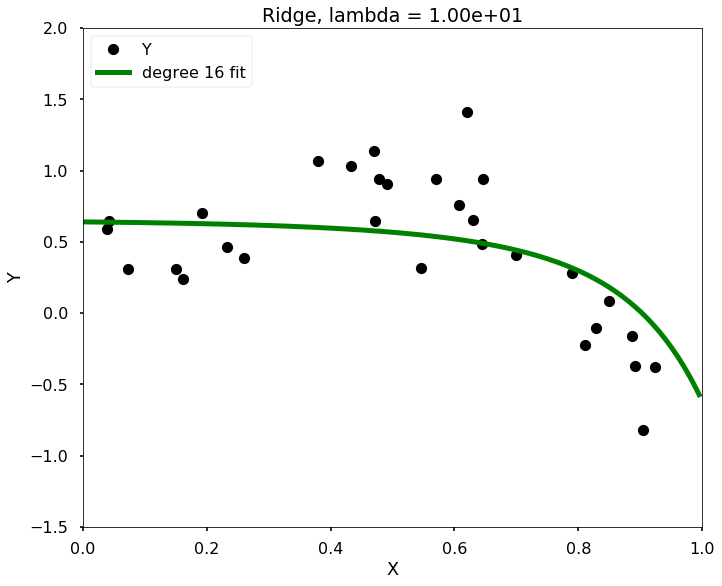

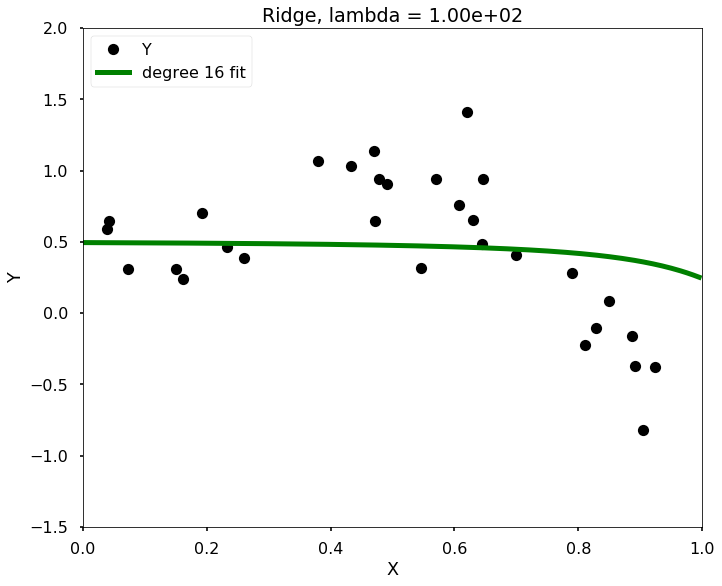

In [23]:
for L2_penalty in [1e-14, 1e-10, 1e-6, 1e-3, 1, 10, 1e2]:
    model = polynomial_ridge_regression(data, deg=16, l2_penalty=L2_penalty)
    print('lambda = %.2e' % L2_penalty)
    print_coefficients(model)
    print('\n')
    plt.figure()
    plot_poly_predictions(data,model)
    plt.title('Ridge, lambda = %.2e' % L2_penalty)

## Find a "good" value for alpha by using the GridSearchCV function to perform "leave one out" (LOO) cross-validation.  

In [24]:
from sklearn.model_selection import GridSearchCV

* Set generic model to Ridge
* Select a range of L2 values
* 16 degree polynomial
* Each cross-validation fold contains only one item.

In [25]:
model = Ridge()
l2_penalty_values = np.logspace(-10, 10, num=10)
grid_values = {'alpha': l2_penalty_values}
deg = 16
folds = len(data) # leave-one-out cross-validation

In [26]:
l2_grid_model = GridSearchCV(model, param_grid = grid_values, cv=folds,
                              scoring = 'neg_mean_squared_error',
                              return_train_score=True)\
                    .fit(polynomial_features(data[['X1']],deg), data.Y)

### best L2 penalty resulting from cross-validation

In [27]:
best_l2_penalty = l2_grid_model.best_params_['alpha']
best_l2_penalty

0.00046415888336127822

### The best L2 penalty is the 4th item

In [28]:
# same as grid_values
l2_grid_model.param_grid

{'alpha': array([  1.00000000e-10,   1.66810054e-08,   2.78255940e-06,
          4.64158883e-04,   7.74263683e-02,   1.29154967e+01,
          2.15443469e+03,   3.59381366e+05,   5.99484250e+07,
          1.00000000e+10])}

### The best L2 penalty has the lowest mean squared error.

In [29]:
l2_grid_model.cv_results_['mean_test_score']

array([-0.26668729, -0.21685512, -0.10933689, -0.08490765, -0.08651656,
       -0.16476773, -0.27290298, -0.27452174, -0.27453152, -0.27453158])

### The training data scores are very overfit for lower alphas.

In [30]:
l2_grid_model.cv_results_['mean_train_score']

array([-0.04701772, -0.0510696 , -0.0527789 , -0.05666332, -0.0656964 ,
       -0.14645296, -0.25452508, -0.25621917, -0.25622942, -0.25622948])

### Polynomial and Plot for the Best L2 Value

In [31]:
best_l2_model = polynomial_ridge_regression(data, deg=deg, l2_penalty=best_l2_penalty)

In [32]:
print_coefficients(best_l2_model)

Learned polynomial for degree 16:
        16         15         14         13         12          11
-1.093 x  + 6.642 x  - 2.581 x  - 4.712 x  - 3.079 x  - 0.9491 x 
           10         9         8         7          6          5
 + 0.5455 x  + 1.287 x + 1.464 x + 1.292 x + 0.9404 x + 0.5244 x
           4          3          2
 + 0.1144 x - 0.2488 x - 0.5448 x - 0.766 x + 0.4914


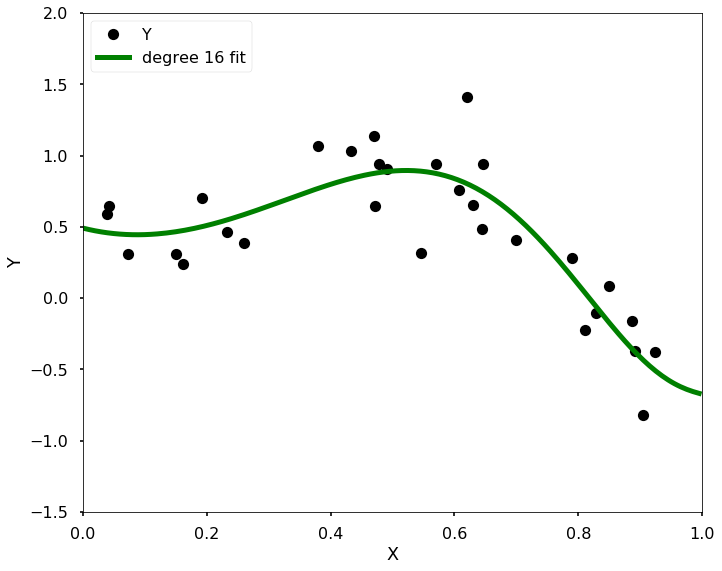

In [33]:
plot_poly_predictions(data,best_l2_model)

## Validation Curve for Lasso Cross-Validation

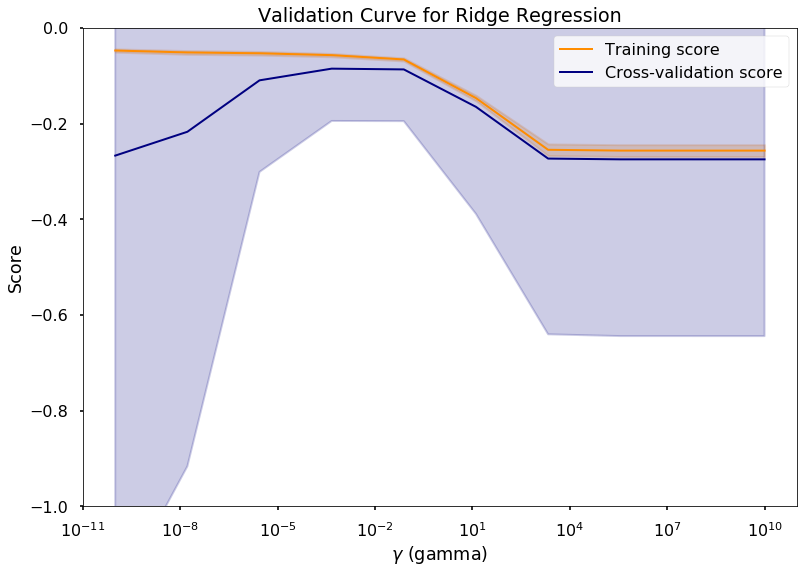

In [67]:
# This code based on scikit-learn validation_plot example
#  See:  http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
plt.figure()

param_range = l2_grid_model.param_grid['alpha']
train_scores_mean = l2_grid_model.cv_results_['mean_train_score']
train_scores_std = l2_grid_model.cv_results_['std_train_score']
test_scores_mean = l2_grid_model.cv_results_['mean_test_score']
test_scores_std = l2_grid_model.cv_results_['std_test_score']

plt.title('Validation Curve for Ridge Regression')
plt.xlabel('$\gamma$ (gamma)')
plt.ylabel('Score')
plt.ylim(-1.0, 0.0)
lw = 2

plt.semilogx(param_range, train_scores_mean, label='Training score',
            color='darkorange', lw=lw)

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.2,
                color='darkorange', lw=lw)

plt.semilogx(param_range, test_scores_mean, label='Cross-validation score',
            color='navy', lw=lw)

plt.fill_between(param_range, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.2,
                color='navy', lw=lw)

plt.legend(loc='best')
plt.show()

# Lasso Regression

Lasso regression jointly shrinks coefficients to avoid overfitting, and implicitly performs feature selection by setting some coefficients exactly to 0 for sufficiently large penalty strength lambda (here called "L1_penalty").  In particular, lasso takes the RSS term of standard least squares and adds a 1-norm cost of the coefficients $\|w\|$.

Define our function to solve the lasso objective for a polynomial regression model of any degree:

In [34]:
def polynomial_lasso_regression(data, deg, l1_penalty):
    y = data.Y
    Xs = polynomial_features(data[['X1']],deg)
    model = Lasso(alpha=l1_penalty, max_iter = 10000000).fit(Xs, y)
    return model

## Explore the lasso solution as a function of a few different penalty strengths

We refer to lambda in the lasso case below as "l1_penalty"

L1_penalty = 1.000000e-06
number of nonzeros = 9
Learned polynomial for degree 16:
        16        15       14         13         12     11         10
-11.16 x  + 63.5 x  - 111 x  + 32.14 x  + 57.88 x  - 0 x  - 13.58 x 
          9     8         5     2
 - 39.57 x - 0 x + 26.46 x - 0 x - 5.684 x + 0.9316

L1_penalty = 1.000000e-05
number of nonzeros = 6
Learned polynomial for degree 16:
        16         15         14     13         11     8     7
-4.987 x  + 24.07 x  - 27.31 x  - 0 x  + 7.845 x  - 0 x - 0 x
           6          5     4     3     2
 - 0.3398 x - 0.9267 x - 0 x - 0 x - 0 x - 0 x + 0.6958

L1_penalty = 1.000000e-04
number of nonzeros = 5
Learned polynomial for degree 16:
         16         15     14         13     12     11         7
-0.4504 x  + 4.545 x  - 0 x  - 7.667 x  - 0 x  - 0 x  + 1.074 x
          6
 + 1.626 x + 0.4478

L1_penalty = 1.000000e-03
number of nonzeros = 3
Learned polynomial for degree 16:
       16     14         13         12     11     10    

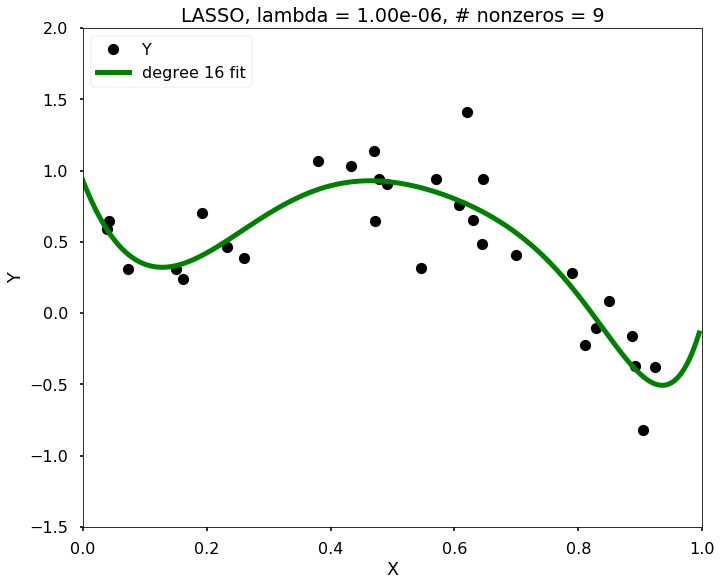

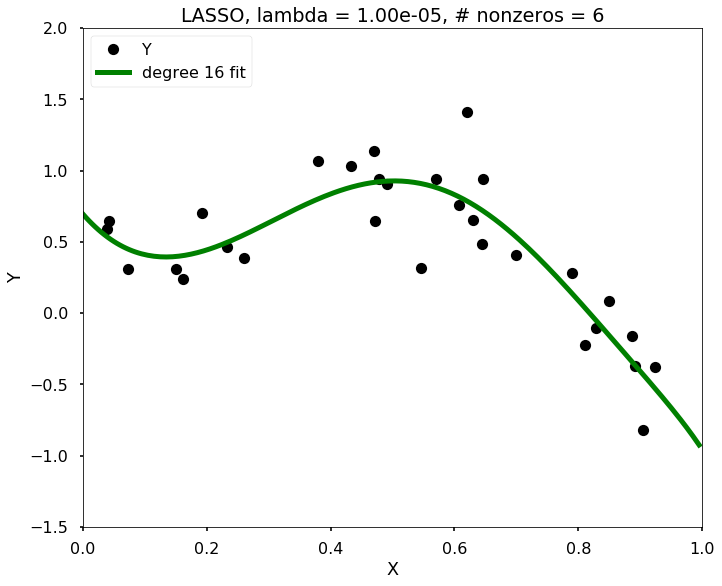

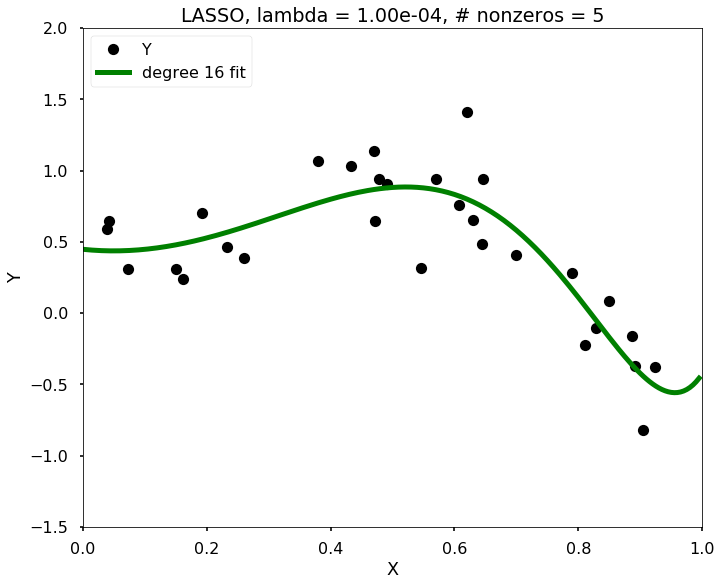

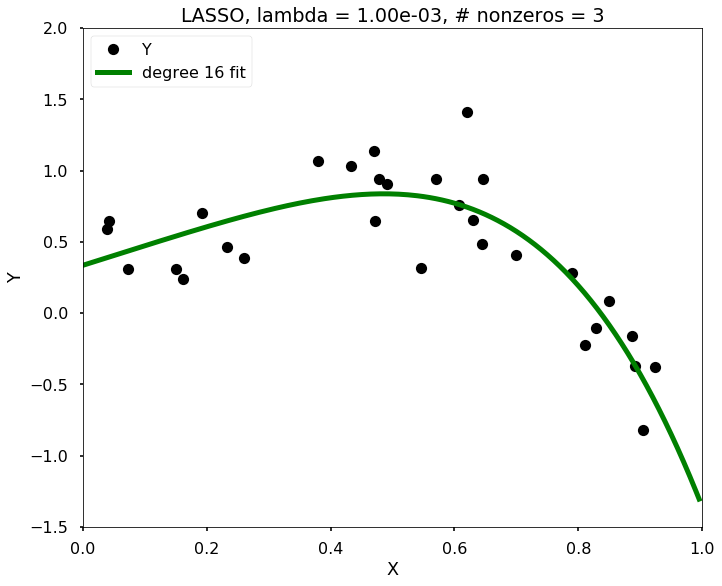

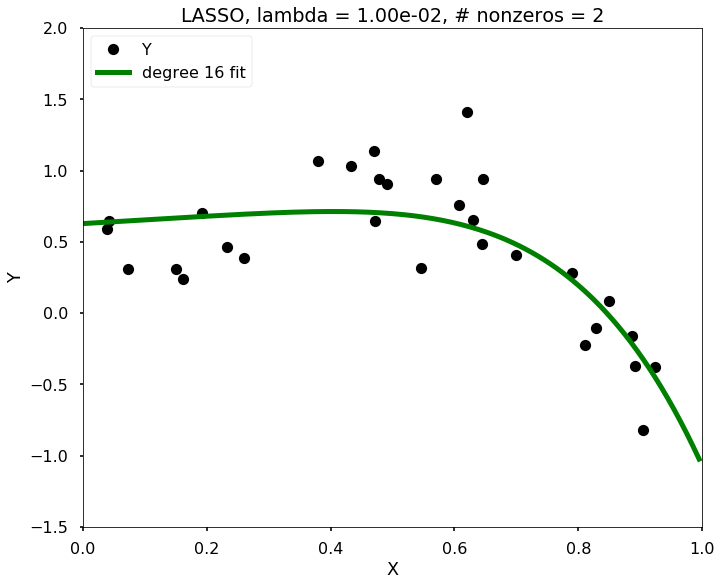

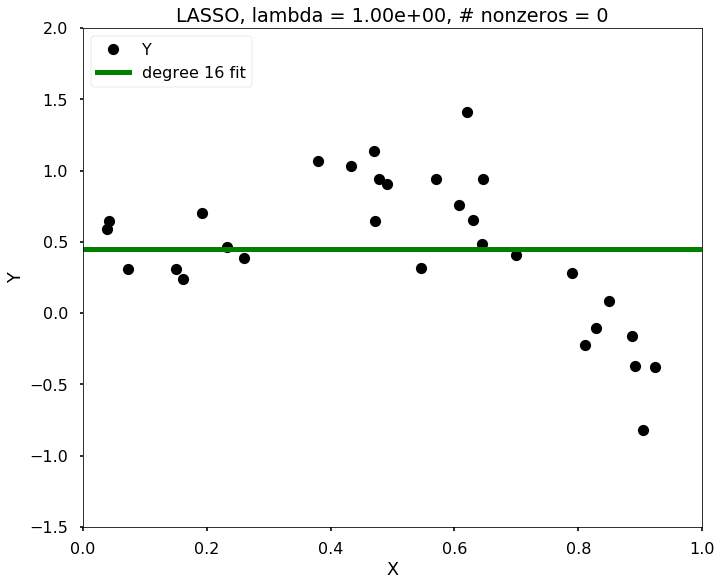

In [35]:
for L1_penalty in [0.000001, 0.00001, 0.0001, 0.001, 0.01, 1.0]:
    model = polynomial_lasso_regression(data, deg=16, l1_penalty=L1_penalty)
    print('L1_penalty = %e' % L1_penalty)
    print('number of nonzeros = %d' % (sum(model.coef_ != 0)))
    print_coefficients(model)
    print()
    plt.figure()
    plot_poly_predictions(data, model)
    plt.title('LASSO, lambda = %.2e, # nonzeros = %d' % (L1_penalty, (sum(model.coef_ != 0))))

In [36]:
model = polynomial_lasso_regression(data, deg=16, l1_penalty = 0.001)

In [37]:
model.coef_

array([ 1.37300157,  0.        , -0.        , -2.88580818, -0.18099104,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [38]:
sum(model.coef_ != 0)

3

## Find a "good" value for alpha by using the GridSearchCV function to perform "leave one out" (LOO) cross-validation. 

* Set generic model to Lasso(max_iter = 10,000,000)
* Select a range of L1 values
* 16 degree polynomial
* Each cross-validation fold contains only one item.

In [39]:
model = Lasso(max_iter = 10000000)
l1_penalty_values = np.logspace(-5, -2, num=12)
grid_values = {'alpha': l1_penalty_values}
deg = 16
folds = len(data) # leave-one-out cross-validation

In [40]:
l1_grid_model = GridSearchCV(model, param_grid = grid_values, cv=folds,
                              scoring = 'neg_mean_squared_error',
                              return_train_score=True)\
                    .fit(polynomial_features(data[['X1']],deg), data.Y)

### best L1 penalty resulting from cross-validation

In [41]:
best_l1_penalty = l1_grid_model.best_params_['alpha']
best_l1_penalty

0.0001232846739442066

### The best L1 penalty is the 5th item

In [42]:
# same as grid_values
l1_grid_model.param_grid

{'alpha': array([  1.00000000e-05,   1.87381742e-05,   3.51119173e-05,
          6.57933225e-05,   1.23284674e-04,   2.31012970e-04,
          4.32876128e-04,   8.11130831e-04,   1.51991108e-03,
          2.84803587e-03,   5.33669923e-03,   1.00000000e-02])}

In [43]:
l1_grid_model.cv_results_['std_test_score']

array([ 0.1433032 ,  0.13039722,  0.11990295,  0.10743953,  0.10413284,
        0.10464867,  0.10560482,  0.10466943,  0.10637518,  0.10905007,
        0.11835296,  0.14769359])

### The best L1 penalty has the lowest mean squared error on the test data.

In [45]:
l1_grid_model.cv_results_['mean_test_score']

array([-0.09458001, -0.09046221, -0.08847294, -0.08341926, -0.08148266,
       -0.08496967, -0.08676368, -0.08267965, -0.08426243, -0.08463101,
       -0.0863383 , -0.10439326])

### The training data scores are overfit for lower alphas, but not as extreme as for ridge regression.

In [46]:
l1_grid_model.cv_results_['mean_train_score']

array([-0.05380105, -0.05428275, -0.05508829, -0.05666366, -0.05792496,
       -0.05891918, -0.0616404 , -0.06353934, -0.06416127, -0.06628647,
       -0.07087898, -0.08550779])

### Polynomial and Plot for the Best L1 Value

In [47]:
best_l1_model = polynomial_lasso_regression(data, deg=deg,
                                            l1_penalty=best_l1_penalty)

In [48]:
print_coefficients(best_l1_model)

Learned polynomial for degree 16:
         16         15     14         13     12     11          6
-0.1371 x  + 3.795 x  - 0 x  - 6.841 x  - 0 x  - 0 x  + 0.8732 x
          5
 + 1.473 x + 0.4242


### Best L1 Model

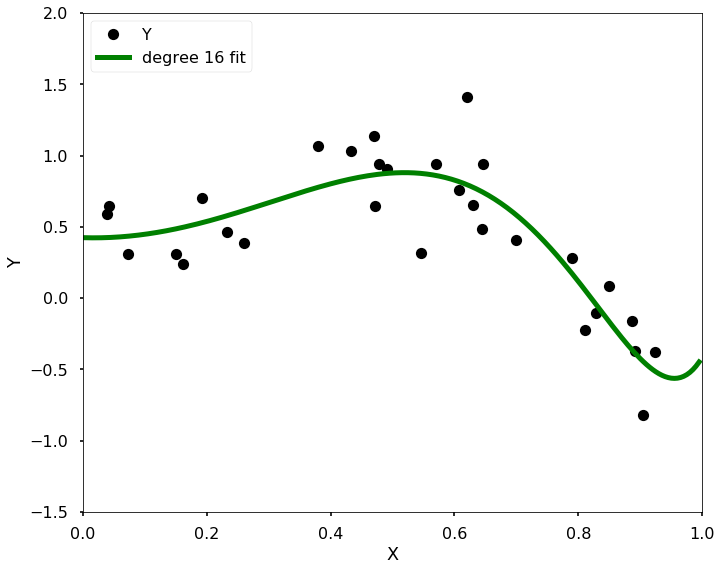

In [49]:
plot_poly_predictions(data,best_l1_model)

### Best L2 Model

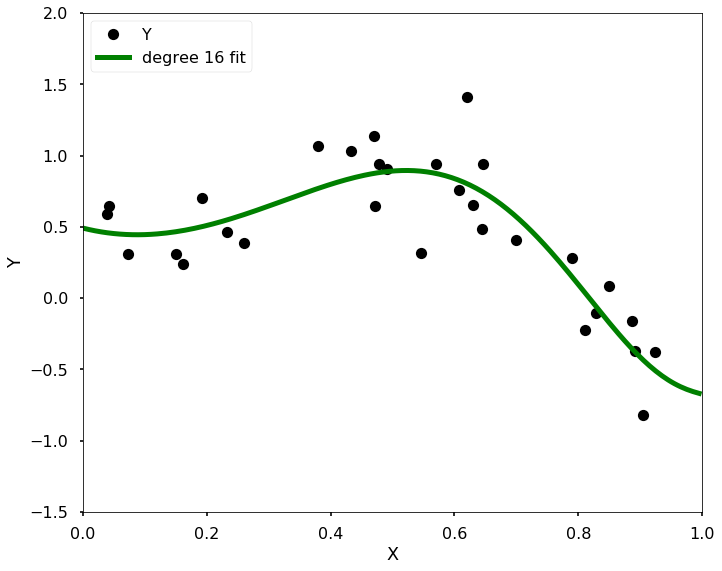

In [50]:
plot_poly_predictions(data,best_l2_model)

### Compare Best L1 and L2 Models

### Compare Coefficients

In [51]:
print(best_l1_model.coef_)
print(best_l1_model.intercept_)

[-0.13712116  3.794536   -0.         -6.84123573 -0.         -0.          0.
  0.          0.          0.          0.87320184  1.47322939  0.          0.
  0.          0.        ]
0.424190422485


In [52]:
print(best_l2_model.coef_)
print(best_l2_model.intercept_)

[-1.09294192  6.6420445  -2.58067471 -4.71238266 -3.07910507 -0.94913204
  0.54550329  1.28727892  1.46366878  1.29164898  0.9404493   0.52439775
  0.11444018 -0.24881144 -0.54483426 -0.76600543]
0.491410345981


### Compare Mean Squared Error

In [53]:
l1_grid_model.cv_results_['mean_test_score'].max()

-0.081482657415936341

In [54]:
l2_grid_model.cv_results_['mean_test_score'].max()

-0.084907650543267071

## Validation Curve for Lasso Cross-Validation

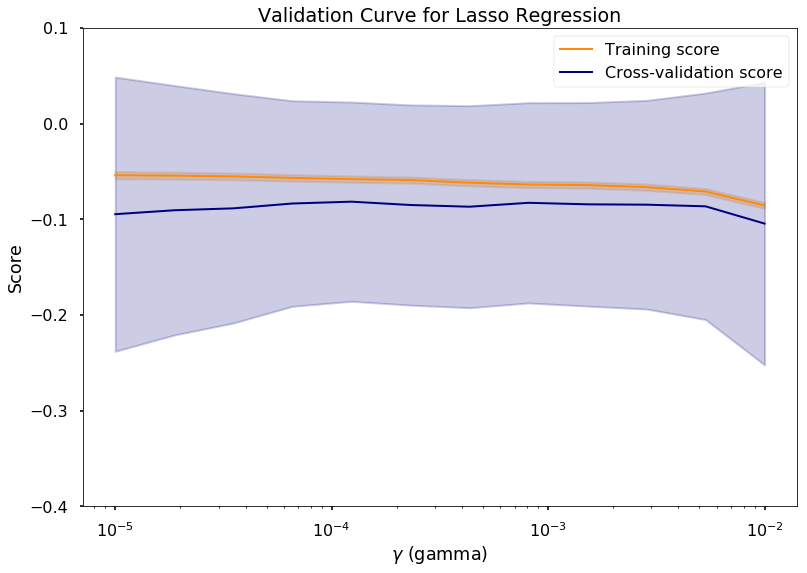

In [73]:
# This code based on scikit-learn validation_plot example
#  See:  http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
plt.figure()

param_range = l1_grid_model.param_grid['alpha']
train_scores_mean = l1_grid_model.cv_results_['mean_train_score']
train_scores_std = l1_grid_model.cv_results_['std_train_score']
test_scores_mean = l1_grid_model.cv_results_['mean_test_score']
test_scores_std = l1_grid_model.cv_results_['std_test_score']

plt.title('Validation Curve for Lasso Regression')
plt.xlabel('$\gamma$ (gamma)')
plt.ylabel('Score')
plt.ylim(-0.4, 0.1)
lw = 2

plt.semilogx(param_range, train_scores_mean, label='Training score',
            color='darkorange', lw=lw)

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.2,
                color='darkorange', lw=lw)

plt.semilogx(param_range, test_scores_mean, label='Cross-validation score',
            color='navy', lw=lw)

plt.fill_between(param_range, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.2,
                color='navy', lw=lw)

plt.legend(loc='best')
plt.show()

## Credits

This Jupyter notebook is adapted from a notebook entitled *Overfitting_Demo_Ridge_Lasso.ipynb* used in week 4 of the course **Machine Learning: Regression**. Among other changes, it has been converted to the scikit-learn ML library from the the Turi library (https://turi.com/).

**Machine Learning: Regression**
University of Washington, Profs. Emily Fox & Carlos Guestrin
https://www.coursera.org/learn/ml-regression/home/welcome